Spring 2022
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center">Lab 6</h3>
<h1 align="center">Convolutional Neural Networks: Part I</h3>
<h3 align="center">Anhar Hassan</h3>

---

**This notebook is based on previous work done by Eng. Shahd Seddik**

Lab partner: Hazem Tarek 201-800-283

#Lab Objectives
* Understand the benefits of using convolutional neural networks (CNNs) over fully connected networks when dealing with raw image data.
* Learn the main components of CNNs and the significance of each component.
* Learn how to build and train a CNN model using the Keras Sequential API.
* Implement the 2D convolution operation.



# Dataset

We will use the [Cat and Dog dataset](https://www.kaggle.com/tongpython/cat-and-dog) we used in the previous lab to train a binary classification model. You will need to downlaod the dataset to your working directory before you can proceed with this lab.

The dataset contains 10,000 RGB images, each containing either cats or dogs. The training set contains 8,000 images, while the test set contains 2,000 images. The classes are balanced.


We will use the following code snippet to download the dataset archive from Google Drive to the Colab instance. Alternatively, you can directly upload the dataset to the Colab machine via the menu on the left.

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1-tXtYSrO5n6L-kAHmxqqjE2GHeC-9za9'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

Notice that the file `archive.zip` is now in the file system. Now, extract it by running the cell below.


In [ ]:
!mkdir /content/cat_and_dog
!unzip -q /content/archive.zip -d /content/cat_and_dog 

Let's take a look at samples from the data.

In [ ]:
import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = os.path.join("/content", "cat_and_dog")
TRAIN_DIR = os.path.join(DATASET_DIR, "training_set", "training_set")
TEST_DIR = os.path.join(DATASET_DIR, "test_set", "test_set")

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))
all_data[:10]

10028


['/content/cat_and_dog/test_set/test_set/dogs/dog.4798.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4166.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4956.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4429.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4017.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4599.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4391.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4640.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4290.jpg',
 '/content/cat_and_dog/test_set/test_set/dogs/dog.4206.jpg']

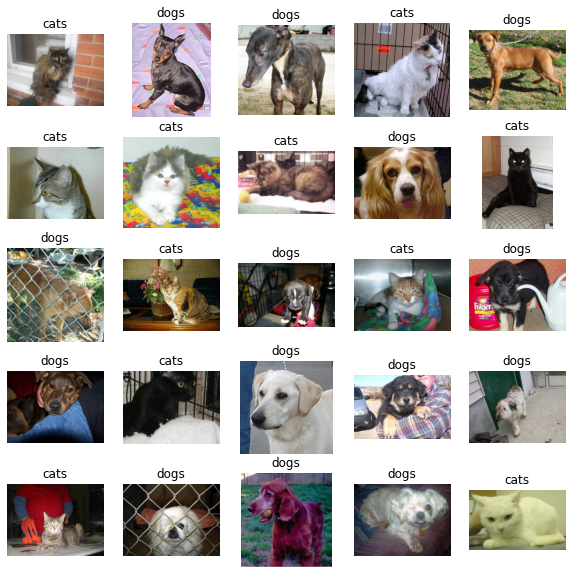

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

## Load Images

To load the dataset and prepare it for the model, we will use the previously introduced `ImageDataGenerator` class provided by Keras. Refer to the previous lab if you need to review the use and benefits of the `ImageDataGenerator` class.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 224
WIDTH = 224
VAL_SPLIT = 0.2

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
      validation_split = VAL_SPLIT
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 6404 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 1601 images belonging to 2 classes.


In [ ]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(rescale = 1.0/255)

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 2023 images belonging to 2 classes.


Let's take a look at some of the images after preprocessing.

In [ ]:
images, labels = next(train_generator)

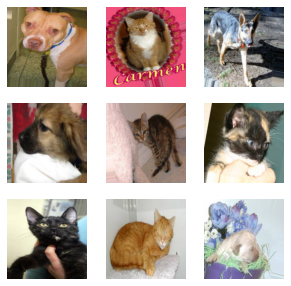

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

# Model

In the previous lab, we used a fully connected model to solve this image classification task. However, we could not reach very high accuracy. Generally, fully connected architectures are not the most suitable for raw image data due to many challenges:
<center><img src="https://cs231n.github.io/assets/challenges.jpeg"></center>

Can you think of more challenges? If only we could extract the relevant features before we feed them into the fully connected network!

The main idea behind CNNs is to learn a hierarchy of features directly from the data instead of hand engineering.

<center><img src="https://i.stack.imgur.com/T3a83.png"></center>

Fully connected network:
<center><img src="https://miro.medium.com/max/1560/1*XvLQwGBqCGl2nnzGTaYZzA.png" ></center>

How can we use spatial structure in the input to inform the architecture of the network? Idea: Connect patches of input to neurons in hidden layer
<center><img src="https://miro.medium.com/max/1570/1*w-kwBOgwteP2L4H0b8So5w.png" ></center>

Connect patch in input layer to a single neuron in subsequent layer. Use a sliding window to define connections. How can we weight the patch to detect particular features?
<center><img src="https://miro.medium.com/max/1460/1*MA8ahxDITPtj6YB0vMuB7A.png" ></center>

The convolution operation is applied as a summation of the element-wise multiplication of the filter with each patch of the input (+ a bias term). Non-linearity can then be applied by introducing a non-linear activation function to the convolution output.

Another important part of CNNs is pooling layers, which represent each patch of the feature map with a summary statistic. They offer two main benefits:
1. Reduced dimensionality
1. Spatial invariance

Can you think of two examples for such pooling functions?


With all our building blocks explained, a simple CNN might look like this:
<center><img src="https://miro.medium.com/max/2000/0*HWj5PgxWxdcld_ye" ></center>



Now, let's build a CNN to solve our classification problem!

<center><img src="https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/05/Cats-Dogs-Classification-deep-learning.gif" ></center>


In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

def model_builder():
  # Specify model architecture
  model = Sequential()
  # Block 1
  model.add(Conv2D(32, (3, 3),
                  activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(HEIGHT, WIDTH, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  # Block 2
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  # FC part
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(2, activation='softmax'))
  
  # Print summary
  model.summary()
  
  # Compile model
  model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
  return model
 
model = model_builder()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_105 (Conv2D)         (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 55, 55, 64)       

## Training

In [ ]:
import tensorflow as tf

NUM_EPOCHS = 20

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks = [earlystop],
                    epochs = NUM_EPOCHS)

Epoch 1/20
101/101 [==============================] - 100s 952ms/step - loss: 3.4759 - accuracy: 0.5350 - val_loss: 0.6884 - val_accuracy: 0.5597
Epoch 2/20
101/101 [==============================] - 95s 939ms/step - loss: 0.6721 - accuracy: 0.5929 - val_loss: 0.6592 - val_accuracy: 0.6377
Epoch 3/20
101/101 [==============================] - 94s 934ms/step - loss: 0.6244 - accuracy: 0.6613 - val_loss: 0.6348 - val_accuracy: 0.6546
Epoch 4/20
101/101 [==============================] - 94s 936ms/step - loss: 0.6087 - accuracy: 0.6733 - val_loss: 0.6182 - val_accuracy: 0.6796
Epoch 5/20
101/101 [==============================] - 94s 933ms/step - loss: 0.5832 - accuracy: 0.6847 - val_loss: 0.5986 - val_accuracy: 0.6827
Epoch 6/20
101/101 [==============================] - 94s 931ms/step - loss: 0.5714 - accuracy: 0.7085 - val_loss: 0.5941 - val_accuracy: 0.7027
Epoch 7/20
 39/101 [==========>...................] - ETA: 47s - loss: 0.5602 - accuracy: 0.7067

## Evaluation

In [ ]:
loss, acc = model.evaluate(test_generator)
print("Test accuracy is {}%".format(100*acc))

32/32 [==============================] - 35s 1s/step - loss: 0.4855 - accuracy: 0.7706
Test accuracy is 77.06376910209656%


# Task

1. [3 pts] Modify the given model in order to achieve test accuracy above 90%.

1. Implement the three functions in the coming cells to perform zero padding and 2D convolution. `zero_pad` is worth 1 pt, `conv_single_step` is worth 2 pts, and `conv_forward` is worth 4 pts.

    Note the following:
>* Each function is explained in detail in the comments.
>* Each function is followed by a cell with driver code that tests your implementation.

    You are allowed to change the function body only. You are **NOT** allowed to:
>* change any of the function signatures or return statements.
>* change the driver code.

# Task 1


1.   **We firstly tried VGG-16 Model without any pre-trained weights, but the Accuracy scores were around 80%**

2.   **We searched and found a simplified version of VGG architecture with much less layers than the VGG-16 architecture, but it has the same structure of conv layers followed by max_pooling layer. We added some drop out layers to it.**

3.   **We reached a score of 82% using the first model.**

4.   **Then we used Transfer Learning for implementing VGG16 with Keras and we reused the model weights from pre-trained models that were developed for standard computer vision benchmark datasets like ImageNet. We have downloaded pre-trained weights that do not have top layers weights from: 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'.**

5. **We replaced the top layers with our own layers and start training the top layers, but using the pre-trained weights.**

6. **VGG-16 scored 92.7%.**



# Model 1: VGG Similar Model

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Sequential
from keras import layers
from keras.applications.vgg16 import VGG16
import tensorflow as tf

def model_builder_VGG():
  # Specify model architecture
  model_VGG_ = Sequential()
  
  # Block 1

  model_VGG_.add(Conv2D(16, (3, 3),
                  activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(224, 224, 3)))
  model_VGG_.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))     
  model_VGG_.add(MaxPooling2D((2, 2), strides = (2,2)))
  model_VGG_.add(Dropout(0.1))

  # Block 2
  model_VGG_.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
  model_VGG_.add(Conv2D(32, (3, 3), activation='relu',padding='same'))

  # Block 3
  model_VGG_.add(MaxPooling2D((3, 3), strides = (2,2)))
  model_VGG_.add(Dropout(0.1))


  # FC part
  model_VGG_.add(Flatten())
  model_VGG_.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model_VGG_.add(Dense(2, activation='softmax'))

  # Print summary
  model_VGG_.summary()
  
  # Compile model
  model_VGG_.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_VGG_
 
model_VGG_ = model_builder_VGG()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 conv2d_133 (Conv2D)         (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_134 (Conv2D)         (None, 112, 112, 32)      4640      
                                                                 
 conv2d_135 (Conv2D)         (None, 112, 112, 32)      9248      
                                                     

## Training

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, patience=20, 
                          verbose=1, mode='auto')

history = model_VGG_.fit(train_generator,
                        validation_data= val_generator, 
                        steps_per_epoch=100,
                        validation_steps=10,epochs=20,
                        callbacks=[checkpoint,earlystop])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.5336
Epoch 1: val_accuracy improved from -inf to 0.58594, saving model to vgg16_1.h5
100/100 [==============================] - 210s 1s/step - loss: 0.8030 - accuracy: 0.5336 - val_loss: 0.6687 - val_accuracy: 0.5859
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.5879
Epoch 2: val_accuracy did not improve from 0.58594
100/100 [==============================] - 105s 1s/step - loss: 0.6597 - accuracy: 0.5879 - val_loss: 0.6924 - val_accuracy: 0.5656
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6524
Epoch 3: val_accuracy improved from 0.58594 to 0.67188, saving model to vgg16_1.h5
100/100 [==============================] - 104s 1s/step - loss: 0.6231 - accuracy: 0.6524 - val_loss: 0.5943 - val_accuracy: 0.6719
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.6838
Epoch 

## Evaluation

In [ ]:
loss, acc = model_VGG_.evaluate(test_generator)
print("Test accuracy is {}%".format(100*acc))

32/32 [==============================] - 9s 268ms/step - loss: 0.4081 - accuracy: 0.8260
Test accuracy is 82.6000988483429%


# Model 2: VGG 16 Architecutre

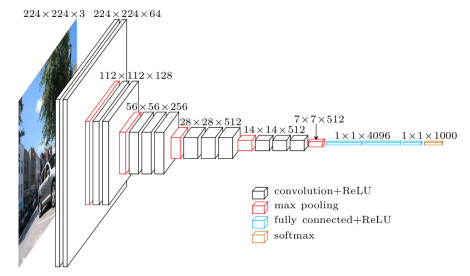


We implmented the previous layers and used the pre-trained weights.
WEIGHTS_PATH_NO_TOP = ('https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') 

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Sequential, Model, load_model
from keras import layers
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras.utils import data_utils



def model_builder_VGG16():
  # Specify model architecture
  model_VGG = Sequential()
  
  # Block 1
  model_VGG.add(Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  input_shape=(HEIGHT, WIDTH, 3)))
  model_VGG.add(Conv2D(64, (3, 3), activation='relu',padding='same'))     
  model_VGG.add(MaxPooling2D((2, 2), strides = (2,2)))

  # Block 2
  model_VGG.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(128, (3, 3), activation='relu',padding='same'))

  # Block 3
  model_VGG.add(MaxPooling2D((2, 2), strides = (2,2)))
  model_VGG.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(256, (3, 3), activation='relu',padding='same'))

  # Block 4
  model_VGG.add(MaxPooling2D((2, 2), strides = (2,2)))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

  # Block 5
  model_VGG.add(MaxPooling2D((2, 2), strides = (2,2)))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
  model_VGG.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

  # Block 6
  model_VGG.add(MaxPooling2D((2, 2), strides = (2,2),name='layer16'))

  # FC part
  model_VGG.add(Flatten())
  model_VGG.add(Dense(256, activation='relu'))
  model_VGG.add(Dense(128, activation='relu'))
  model_VGG.add(Dense(2, activation='softmax'))


  VGG_16 = Model(inputs=model_VGG.input, outputs=model_VGG.get_layer('layer16').output)

  WEIGHTS_PATH_NO_TOP = ('https://storage.googleapis.com/tensorflow/'
                       'keras-applications/vgg16/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
  
  weights_path = data_utils.get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
          WEIGHTS_PATH_NO_TOP,
          cache_subdir='models',
          file_hash='6d6bbae143d832006294945121d1f1fc')
  
  VGG_16.load_weights(weights_path)

  
  for layer in VGG_16.layers:
    layer.trainable = False

  for layer in model_VGG.layers:
    print(layer, layer.trainable)
  
  # Compile model
  model_VGG.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

  # Print summary
  model_VGG.summary()

  return model_VGG
 
model_VGG = model_builder_VGG16()

58900480/58889256 [==============================] - 1s 0us/step
<keras.layers.convolutional.Conv2D object at 0x7f753032af10> False
<keras.layers.convolutional.Conv2D object at 0x7f743f514c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f744b744f10> False
<keras.layers.convolutional.Conv2D object at 0x7f7530337950> False
<keras.layers.convolutional.Conv2D object at 0x7f75302c6c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f753033b710> False
<keras.layers.convolutional.Conv2D object at 0x7f75304e4c50> False
<keras.layers.convolutional.Conv2D object at 0x7f7530391910> False
<keras.layers.convolutional.Conv2D object at 0x7f753025d510> False
<keras.layers.pooling.MaxPooling2D object at 0x7f753b4fb750> False
<keras.layers.convolutional.Conv2D object at 0x7f75302c6790> False
<keras.layers.convolutional.Conv2D object at 0x7f7530498110> False
<keras.layers.convolutional.Conv2D object at 0x7f753026b810> False
<keras.layers.pooling.MaxPooling2D object at 0x7f744b892a10> Fal

## Training

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_2.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, patience=20, 
                          verbose=1, mode='auto')

history = model_VGG.fit(train_generator,
                        validation_data= val_generator, 
                        steps_per_epoch=100,
                        validation_steps=10,epochs=20,
                        callbacks=[checkpoint,earlystop])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7022
Epoch 1: val_accuracy improved from -inf to 0.68281, saving model to vgg16_2.h5
100/100 [==============================] - 120s 1s/step - loss: 0.6206 - accuracy: 0.7022 - val_loss: 0.6363 - val_accuracy: 0.6828
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8366
Epoch 2: val_accuracy improved from 0.68281 to 0.89531, saving model to vgg16_2.h5
100/100 [==============================] - 119s 1s/step - loss: 0.3548 - accuracy: 0.8366 - val_loss: 0.2559 - val_accuracy: 0.8953
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8748
Epoch 3: val_accuracy improved from 0.89531 to 0.90781, saving model to vgg16_2.h5
100/100 [==============================] - 119s 1s/step - loss: 0.2861 - accuracy: 0.8748 - val_loss: 0.2254 - val_accuracy: 0.9078
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 

## Evaluation

In [ ]:
loss, acc = model_VGG.evaluate(test_generator)
print("Test accuracy is {}%".format(100*acc))

32/32 [==============================] - 24s 735ms/step - loss: 0.2007 - accuracy: 0.9273
Test accuracy is 92.73356199264526%


# Task 2

The first required function performs zero-padding. (Hint: Do not forget that zero-padding is applied to the image vertically and horizontally.)

In [ ]:
import numpy as np

def zero_pad(X, pad):
  """
  Pad with zeros all images of the dataset or batch X.
  
  Arguments:
    - X -- numpy array of shape (n, h, w, c) representing a batch of n images
    - pad -- integer, padding amount
  
  Returns:
    - X_pad -- padded image of shape (n, h + 2*pad, w + 2*pad, c)
  """
  # Perform the padding
  dim_pad = (X.shape[0], X.shape[1]+2*pad, X.shape[2]+2*pad, X.shape[3])
  X_pad=np.zeros(dim_pad)

  for n in range(X.shape[0]):
    X_pad[n, pad: pad+X.shape[1], pad: pad+X.shape[2], :] = X[n,:, :, :]


  return X_pad

x.shape = (10, 3, 3, 2)
x_pad.shape = (10, 7, 7, 2)
x[1] = [[[ 0.27445992 -1.52652453]
  [ 1.65069969  0.15433554]
  [-0.38713994  2.02907222]]

 [[-0.04538603 -1.4506787 ]
  [-0.40522786 -2.2883151 ]
  [ 1.04939655 -0.41647432]]

 [[-0.74255353  1.07247013]
  [-1.65107559  0.53542936]
  [-2.0644148  -0.66215934]]]
x_pad[1] = [[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.27445992 -1.52652453]
  [ 1.65069969  0.15433554]
  [-0.38713994  2.02907222]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [-0.04538603 -1.4506

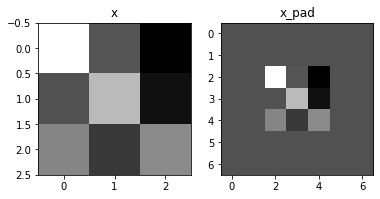

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(7)
x = np.random.randn(10, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1] =", x[1])
print ("x_pad[1] =", x_pad[1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0], cmap='gray')
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0], cmap='gray')

The second required function performs part of the convolution operation, in which the filter is convolved with an equal-sized patch of the input as the shown in the simple example below.

<center><img src = "https://miro.medium.com/max/1035/1*XgwS9cyDMb5FCiCJ4_z6ZQ.png"></center>

In [ ]:
def conv_single_step(input_slice, W, b):
  """
  Apply one filter on a single slice of the layer's input.
  
  Arguments:
    - input_slice -- slice of input data of shape (f, f, c)
    - W -- Weight parameters of the filter - matrix of shape (f, f, c)
    - b -- Bias parameter associated with the filter - matrix of shape (1, 1, 1)
  
  Returns:
    - Z -- result of convolving the sliding filter with a slice of the input data 
            - a scalar value
  """
  # Element-wise product between input_slice and W
  m = np.multiply(input_slice, W)
  # Sum the product found in the previous line
  sum = np.sum(m) 
  # Add bias term. Do not forget to perform any type-casting necessary to
  # end up with a scalar value.
  Z = float(sum + b)

  return Z

In [ ]:
np.random.seed(7)
input_slice = np.random.randn(5, 5, 3)
W = np.random.randn(5, 5, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(input_slice, W, b)
print("Z =", Z)

Z = 0.6123630274271965


The final function performs a forward-pass of convolution.

In [ ]:
def conv_forward(X, W, b, stride=1, pad=0):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    X -- output activations of the previous layer, numpy array of shape (n, h_in, w_in, c_in)
    W -- Weights, numpy array of shape (f, f, c_in, n_filter)
    b -- Biases, numpy array of shape (1, 1, 1, n_filter)
    stride -- integer
    pad -- integer
        
    Returns:
    Z -- conv output, numpy array of shape (n, h_out, w_out, c_out)
    """
    
    # Retrieve dimensions from X's shape 
    (n, h_in, w_in, c_in) = X.shape
    
    # Retrieve dimensions from W's shape
    (f, f, c_in, n_filter) = W.shape
    
    # Compute the dimensions of the CONV output volume
    h_out = round((h_in + 2*pad - f)/stride) + 1
    w_out = round((w_in + 2*pad - f)/stride) + 1
    conv_shape=(n, h_out, w_out, n_filter)

    # Initialize the output volume Z with zeros
    Z = np.zeros(conv_shape)
    
    # Create X_pad by padding X
    X_pad = zero_pad(X, pad)
    
    # loop over the batch of training examples
    for i in range(n):
        # Select ith training example's padded activation
        a = X_pad[i,:,:,:]
        # loop over vertical axis of the output volume
        for ver in range(h_out):
          # loop over horizontal axis of the output volume
          for hor in range(w_in):
            # loop over channels (= #filters) of the output volume
            for c in range(n_filter):        
              # Find the corners of the current "slice"
              curr_slice = a[ver*stride: ver*stride+f, hor*stride: hor*stride+f, :]      
              # Use the corners to define the (3D) slice of x_in_pad                   
              # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
              Z[i, ver, hor, c] = conv_single_step(curr_slice, W[:,:,:,c], b[:,:,:,c])

    
    # Making sure your output shape is correct
    assert(Z.shape == (n, h_out, w_out, n_filter))
    
    return Z

In [ ]:
np.random.seed(7)

X = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
pad = 2
stride = 2

Z = conv_forward(X, W, b, stride, pad)

print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])

Z's mean = 0.41278185109159277
Z[3,2,1] = [-4.11098244  0.00992554 -0.64602682 -4.27469975  0.13846572 -0.55589245
  5.08703266  1.11798612]


## Bonus

Object Detection is one of many applications in which CNNs shine. It is the task of locating and identefiying an object in any part of an image. It is even more sophisticated in videos which is the first step in object tracking. Object detection has many applications in robot vision and understanding, autonomous driving, and medicine.


Your task is to read and understand this review paper; A review paper typically makes a review -by definition- of the literature in the topic in-hand and saves a lot of time to let you know which angel you shall read alot from [A Review of Object Detection Models based on Convolutional Neural Network
](https://arxiv.org/abs/1905.01614)to see how CNNs can be employed to solve a problem as complex as object detection. Then, answer the following questions:

1. [0.5 pt] What is the main difference between two-stage vs. one-stage object detection?

> (Two-stage models gave higher localization and recognition accuracy than one-stage models in object detection but Two-stage models are slower than One-stage.)

1. [1 pt] Choose one model from the review, and talk about it, and what you think could be improved?

> *R-CNN*: it is the first CNN that is based on two stage object detection model. R-CNN Architecture is composed of 3 blocks. In the first block, selective search is used to generate 2000 class-independent regions from each input image. Secondly, five conv layers and two FC layers are used to extract the feature vector. Thirdly, each region is classified using SVM.)

> R-CNN has some problems as its training is expensive in terms of time and space, also it is slow.

> Fast R-CNN and SPP came to solve some problems in R-CNN and they led to a faster object detection by not feeding the full 2000 class-independent regions to the network, but the processing is done only once per image and then the feature vector is generated.

1. [0.5 pt] What did you find difficult to understand when reading the paper? 
(Hint: There is no right or wrong answer :))

> (I didn't understand how VGG-16 and ResNet 101 are combined in RefineDet Model and how this led to an improvement.)



References
* [MIT 6.S191: Introduction to Deep Learning](introtodeeplearning.com)
* https://github.com/lhk/convolution
